In [22]:
# !pip install scikit-plot

In [23]:
# !pip install seaborn scikit-plot


Best hyperparameters: {'knn__n_neighbors': 10, 'pca__n_components': 20}


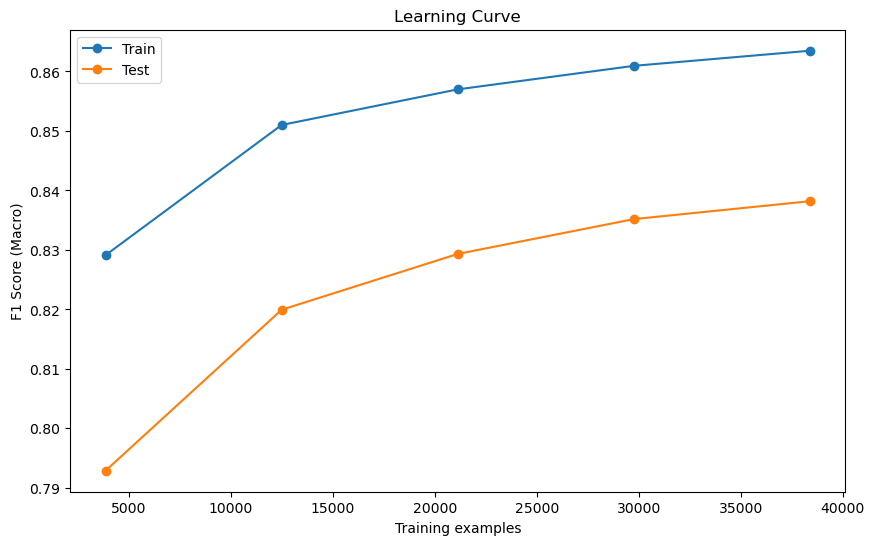

Accuracy on test set: 0.832
Classification Report on test set:
               precision    recall  f1-score   support

           0       0.77      0.82      0.79      1000
           1       0.98      0.94      0.96      1000
           2       0.74      0.75      0.74      1000
           3       0.83      0.85      0.84      1000
           4       0.70      0.75      0.72      1000
           5       0.94      0.87      0.90      1000
           6       0.64      0.54      0.58      1000
           7       0.88      0.91      0.89      1000
           8       0.95      0.94      0.95      1000
           9       0.90      0.94      0.92      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



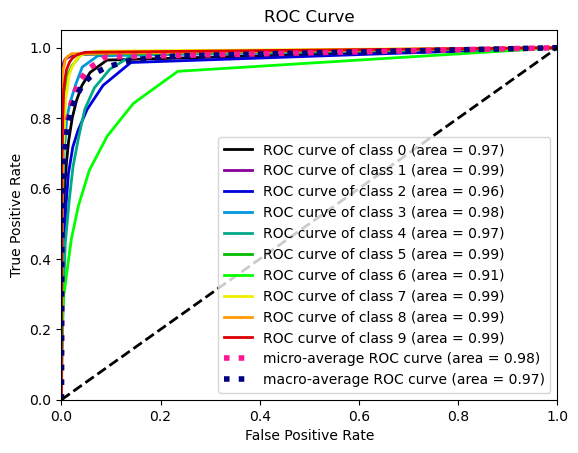

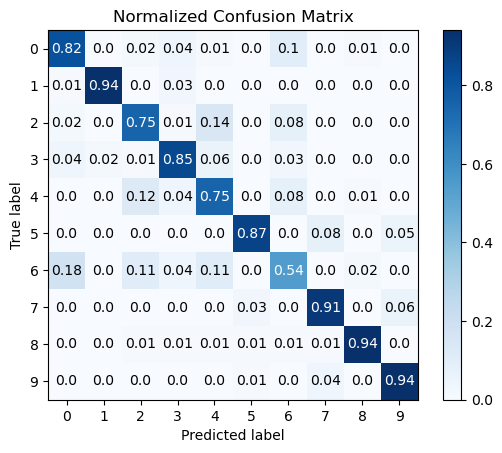

In [20]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score, classification_report, make_scorer, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

class KNNWithPCA:
    def __init__(self, n_neighbors=5, n_components=50):
        self.n_neighbors = n_neighbors
        self.n_components = n_components
        self.model = self._build_pipeline()

    def _build_pipeline(self):
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=self.n_components)),
            ('knn', KNeighborsClassifier(n_neighbors=self.n_neighbors))
        ])
        return pipeline

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def evaluate(self, X_test, y_test):
        y_pred = self.model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        return accuracy, report

    def tune_hyperparameters(self, X_train, y_train, param_grid, cv=5, n_jobs=-1):
        explained_variance_threshold = 0.8 # Adjust as needed

        pca_n_components = [n for n in param_grid['pca__n_components'] if n > 0]
        grid_search = GridSearchCV(self.model, param_grid, cv=cv, n_jobs=n_jobs, scoring='f1_macro')

        # Add logic to check explained variance
        best_explained_variance = 0.0
        best_pca_components = None

        for n_components in pca_n_components:
            self.model.named_steps['pca'].set_params(n_components=n_components)
            grid_search.fit(X_train, y_train)

            # Check if explained variance meets the threshold
            explained_variance_ratio = np.sum(grid_search.best_estimator_.named_steps['pca'].explained_variance_ratio_)
            if explained_variance_ratio > explained_variance_threshold and explained_variance_ratio > best_explained_variance:
                best_explained_variance = explained_variance_ratio
                best_pca_components = n_components

        # Update the param_grid with the best PCA components
        param_grid['pca__n_components'] = [best_pca_components] if best_pca_components is not None else pca_n_components

        # Rerun grid search with the updated param_grid
        grid_search = GridSearchCV(self.model, param_grid, cv=cv, n_jobs=n_jobs, scoring='f1_macro')
        grid_search.fit(X_train, y_train)

        self.model = grid_search.best_estimator_
        return grid_search.best_params_

    def plot_learning_curve(self, X_train, y_train, X_val, y_val, X_test, y_test):
        # Your implementation of the learning curve plotting, adjust as needed
        # This is a basic example, and you may want to customize it based on your needs
        train_sizes, train_scores, test_scores = learning_curve(
            estimator=self.model, X=X_train, y=y_train, cv=5, scoring='f1_macro', n_jobs=-1)

        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)

        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, train_scores_mean, label='Train', marker='o')
        plt.plot(train_sizes, test_scores_mean, label='Test', marker='o')
        plt.title('Learning Curve')
        plt.xlabel('Training examples')
        plt.ylabel('F1 Score (Macro)')
        plt.legend()
        plt.show()

    def plot_roc_curve(self, X_test, y_test):
        y_probas = self.model.predict_proba(X_test)
        skplt.metrics.plot_roc(y_test, y_probas)
        plt.title("ROC Curve")
        plt.show()

    def plot_confusion_matrix(self, X_test, y_test):
        y_pred = self.model.predict(X_test)
        skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
        plt.title("Normalized Confusion Matrix")
        plt.show()

    def plot_metric_vs_complexity_3d(self, X_train, y_train, X_val, y_val, pca_components, knn_neighbors, metric='macro'):
            """
            Plot a 3D graph of a classification metric vs. model complexity.
    
            Parameters:
            - X_train, y_train: Training data
            - X_val, y_val: Validation data
            - pca_components: List of values for PCA components
            - knn_neighbors: List of values for KNN neighbors
            - metric: Classification metric to plot (default: 'f1_macro')
            """
            fig = plt.figure(figsize=(12, 8))
            ax = fig.add_subplot(111, projection='3d')
    
            pca_values, knn_values, metric_values = [], [], []
    
            for pca_comp in pca_components:
                for knn_neigh in knn_neighbors:
                    # Set the hyperparameter values
                    self.model.named_steps['pca'].set_params(n_components=pca_comp)
                    self.model.named_steps['knn'].set_params(n_neighbors=knn_neigh)
    
                    # Train the model
                    self.model.fit(X_train, y_train)
    
                    # Evaluate on validation set
                    val_pred = self.model.predict(X_val)
                    val_score = f1_score(y_val, val_pred, average=metric)
    
                    pca_values.append(pca_comp)
                    knn_values.append(knn_neigh)
                    metric_values.append(val_score)
    
            ax.scatter(pca_values, knn_values, metric_values, c=metric_values, cmap='viridis')
            ax.set_xlabel('Number of PCA Components')
            ax.set_ylabel('Number of Neighbors (KNN)')
            ax.set_zlabel(f'{metric.capitalize()} Score')
            ax.set_title(f'{metric.capitalize()} vs. Model Complexity')
    
            # Set the viewing angle for better visibility
            ax.view_init(elev=20, azim=30)
    
            # Adjust axis limits to cover the entire range of values
            ax.set_xlim(min(pca_components), max(pca_components))
            ax.set_ylim(min(knn_neighbors), max(knn_neighbors))
            ax.set_zlim(min(metric_values), max(metric_values))
    
            plt.show()
        


    # def plot_metric_vs_complexity_3d(self, X_train, y_train, X_val, y_val, pca_components, knn_neighbors, metric='weighted'):
    #     """
    #     Plot a 3D graph of a classification metric vs. model complexity.

    #     Parameters:
    #     - X_train, y_train: Training data
    #     - X_val, y_val: Validation data
    #     - pca_components: List of values for PCA components
    #     - knn_neighbors: List of values for KNN neighbors
    #     - metric: Classification metric to plot (default: 'f1_macro')
    #     """
    #     fig = plt.figure(figsize=(12, 8))
    #     ax = fig.add_subplot(111, projection='3d')

    #     pca_values, knn_values, metric_values = [], [], []

    #     for pca_comp in pca_components:
    #         for knn_neigh in knn_neighbors:
    #             # Set the hyperparameter values
    #             self.model.named_steps['pca'].set_params(n_components=pca_comp)
    #             self.model.named_steps['knn'].set_params(n_neighbors=knn_neigh)

    #             # Train the model
    #             self.model.fit(X_train, y_train)

    #             # Evaluate on validation set
    #             val_pred = self.model.predict(X_val)
    #             val_score = f1_score(y_val, val_pred, average=metric)

    #             pca_values.append(pca_comp)
    #             knn_values.append(knn_neigh)
    #             metric_values.append(val_score)

    #     ax.scatter(pca_values, knn_values, metric_values, c=metric_values, cmap='viridis')
    #     ax.set_xlabel('Number of PCA Components')
    #     ax.set_ylabel('Number of Neighbors (KNN)')
    #     ax.set_zlabel(f'{metric.capitalize()} Score')
    #     ax.set_title(f'{metric.capitalize()} vs. Model Complexity')
    #     plt.show()

    
# Assuming you have your data loaded in X_train, y_train, X_val, y_val, X_test, y_test
from tensorflow.keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))

    # Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Instantiate the KNNWithPCA class
knn_pca = KNNWithPCA()

# Hyperparameter tuning with explained variance condition
param_grid = {
    'pca__n_components': [5, 10, 20, 50, 100, 150, 200],
    'knn__n_neighbors': [3, 5, 7, 10, 15],
}

best_params = knn_pca.tune_hyperparameters(X_train, y_train, param_grid)
print("Best hyperparameters:", best_params)

# Train the model with the best hyperparameters
knn_pca.train(X_train, y_train)

# Plot Learning Curve
knn_pca.plot_learning_curve(X_train, y_train, X_val, y_val, X_test, y_test)

# Evaluate the model on the test set
accuracy, report = knn_pca.evaluate(X_test, y_test)
print(f"Accuracy on test set: {accuracy}")
print("Classification Report on test set:\n", report)

# Plot ROC Curve
knn_pca.plot_roc_curve(X_test, y_test)

# Plot Confusion Matrix
knn_pca.plot_confusion_matrix(X_test, y_test)


/tmp/ipykernel_879744/1409746655.py:139: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(min(pca_components), max(pca_components))


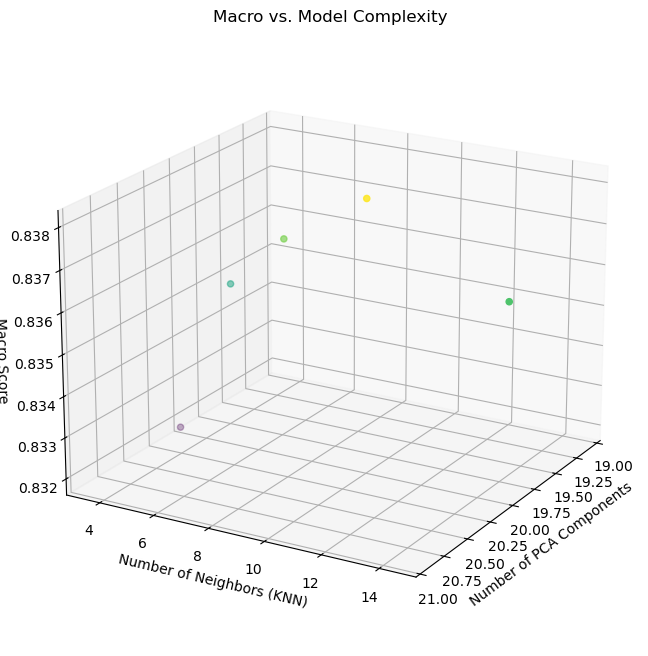

In [21]:
knn_pca.plot_metric_vs_complexity_3d(X_train, y_train, X_val, y_val,param_grid['pca__n_components'],param_grid['knn__n_neighbors'])
